In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

In [29]:
BATCH_SIZE = 100

trainval_data = FashionMNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())

train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))   #train data size:  48000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
print("val data size: ",len(val_data))   #val data size:  12000
print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120

train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([9, 7, 7, 1, 1, 5, 2, 0, 3, 1])


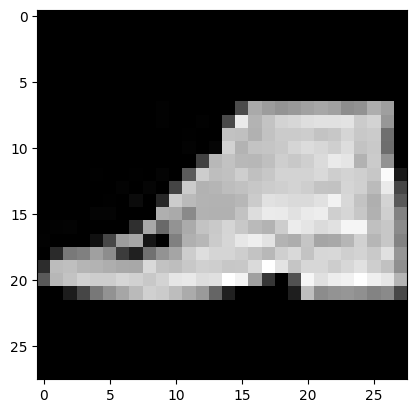

In [30]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')


In [31]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev


In [32]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss


In [33]:
z_dim = 2
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z, ave, log_dev = model(input)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z, ave, log_dev = model(input)

      loss = criterion(output, input, ave, log_dev)
      history["val_loss"].append(loss)
      
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()

torch.save(model, './model/model_vae2.pt')


Epoch: 1, loss:  32851.5977
Epoch: 1, loss:  29432.7207
Epoch: 1, loss:  29972.5918
Epoch: 1, loss:  27877.8730
Epoch: 1, loss:  28334.0215
Epoch: 1, loss:  27695.6543
Epoch: 1, loss:  28067.9355
Epoch: 1, loss:  27828.3672
Epoch: 1, loss:  28084.3828
Epoch: 1, val_loss:  26887.2109
Epoch: 2, loss:  27031.8242
Epoch: 2, loss:  28384.9844
Epoch: 2, loss:  27817.6172
Epoch: 2, loss:  26069.2656
Epoch: 2, loss:  26711.8965
Epoch: 2, loss:  26458.7109
Epoch: 2, loss:  28091.3301
Epoch: 2, loss:  27761.6562
Epoch: 2, loss:  26215.6992
Epoch: 2, val_loss:  26985.0371
Epoch: 3, loss:  28094.9395
Epoch: 3, loss:  27370.8730
Epoch: 3, loss:  25022.4941
Epoch: 3, loss:  26513.3457
Epoch: 3, loss:  26941.8418
Epoch: 3, loss:  26733.5840
Epoch: 3, loss:  26568.4082
Epoch: 3, loss:  25957.4648
Epoch: 3, loss:  27416.5078
Epoch: 3, val_loss:  27573.5684
Epoch: 4, loss:  26179.5410
Epoch: 4, loss:  25546.3184
Epoch: 4, loss:  27378.5977
Epoch: 4, loss:  26396.1445
Epoch: 4, loss:  26340.8848
Epoch: 4

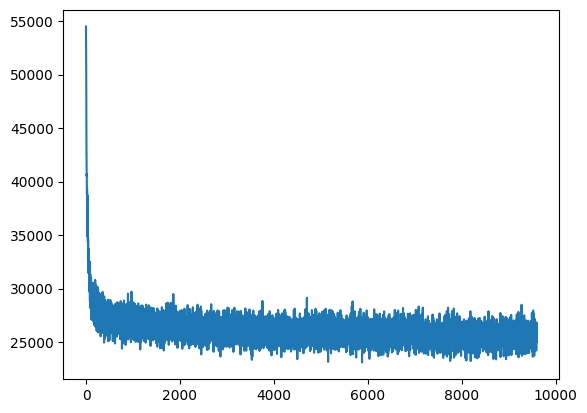

In [34]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)


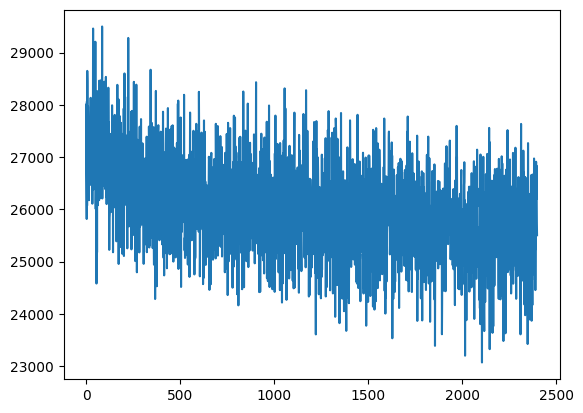

In [35]:
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)


In [36]:
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_dev"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(ave_tensor.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor.size())   #torch.Size([9600, 100, 2])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)   #(9600, 100, 2)
print(log_var_np.shape)   #(9600, 100, 2)
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)


torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100, 2)
(9600, 100, 2)
(9600, 100)


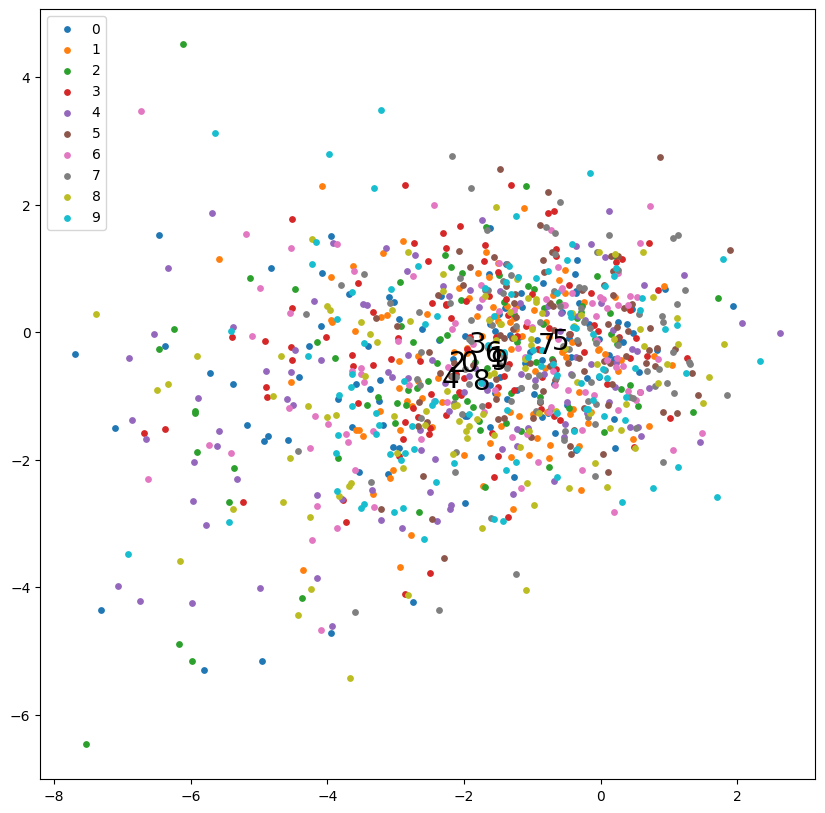

In [37]:
map_keyword = "tab10"
cmap = plt.get_cmap(map_keyword)

batch_num =10
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[:batch_num,:,0][labels_np[:batch_num,:] == label]
  y = z_np[:batch_num,:,1][labels_np[:batch_num,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


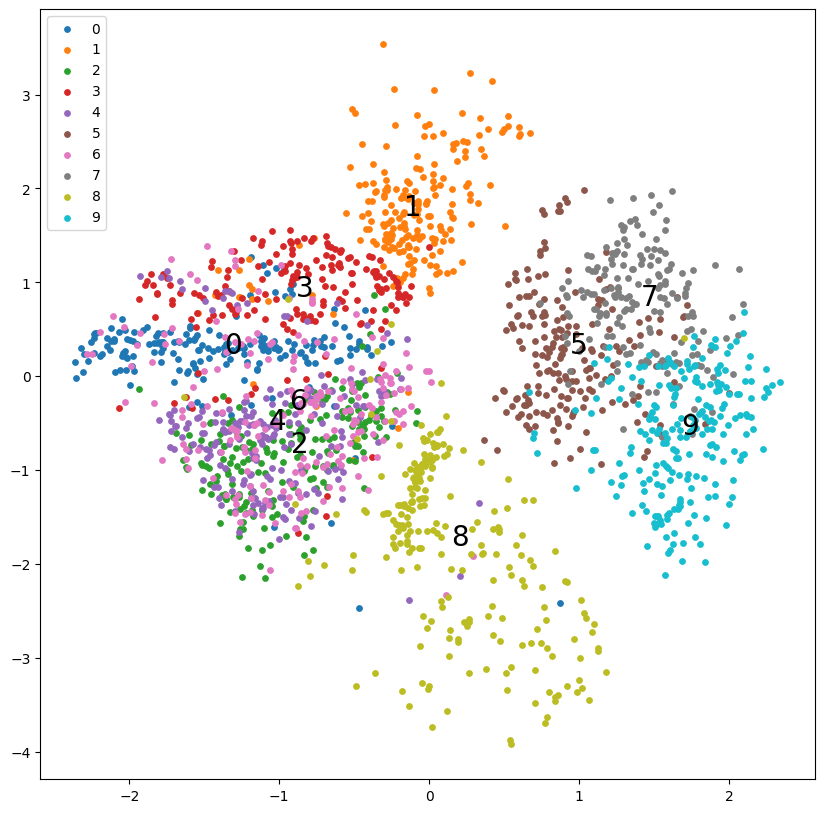

In [38]:
batch_num = 9580
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
  y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


In [39]:
model = torch.load('./model/model_vae2.pt')

images_size: torch.Size([100, 1, 28, 28])
label: tensor([3, 0, 4, 4, 6, 5, 1, 5, 6, 4])


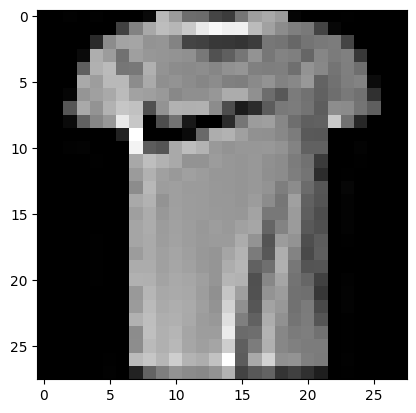

In [40]:
label = 1
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[label,0,:,:], cmap='gray')

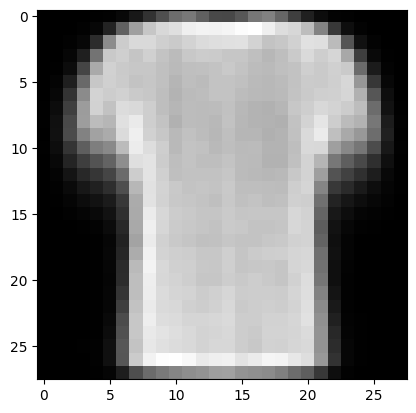

In [41]:
model.to("cpu")

#x_zero_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
#y_zero_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
#z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)

z=images[label][0].to("cpu")
z=input = z.view(-1, 28*28).to(torch.float32)

output = model(z)
np_output = output[0].to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')
